In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from matplotlib.patches import Rectangle

In [30]:
def load_chromosomes(fstem,fdir):

    fsearch = fdir + fstem + '*.linear'
    files = glob.glob(fsearch)
    if len(files) == 0:
        print('no files!')
        return

    variants = {}  # key = chromosome numbers; values = list of SNPs
    positions = {} # key = chromosome numbers; values = list of positions
    pvals = {} # key = chromosome numbers; values = list of pvals
    betas = {} # key = chromosome numbers; values = list of betas

    for file in files:
        chrnum = int(file.split('/')[1].split(fstem)[1].split('.')[0])
        positions[chrnum] = []
        pvals[chrnum] = []
        variants[chrnum] = []
        betas[chrnum] = []
        
        #print('Loading chromosome ' + str(chrnum))
        with open(file,'r') as f:
            header = f.readline()
            for line in f:
                stuff = line.rstrip().split()
                if len(stuff) > 8:
                    variants[chrnum].append(stuff[1])
                    positions[chrnum].append(int(stuff[2]))
                    
                    if 'NA' in stuff[8]:
                        p = float('nan')
                        beta = p
                    else:
                        p = float(stuff[8])
                        beta = float(stuff[6])
                    pvals[chrnum].append(-np.log10(p))
                    betas[chrnum].append(beta)
                else:
                    print(str(chrnum) + ' appears to be truncated')
    print('done loading chromosomes')
    return positions, variants, pvals, betas

def variant_pval_dict(variantDict,pvalDict):
    allVariants = []
    allPvals = []
    for chrom in sorted(pvalDict.keys()):
        allVariants.extend(variantDict[chrom])
        allPvals.extend(pvalDict[chrom])
    variantPvals = dict(zip(allVariants,allPvals))
    return variantPvals

In [26]:
# load GWAS data for a particular experiment
fstem = 'qualifications_noMove'
fdir = 'qualifications_noMove_95k/'
noMovepositions, noMovevariants, noMovepvals, noMovebetas = load_chromosomes(fstem,fdir)

done loading chromosomes


In [46]:
# get snps of interest
chr_of_interest = 3 # 3, 6, 9, 11
chrpvals = np.array(noMovepvals[chr_of_interest])
chrvariants = np.array(noMovevariants[chr_of_interest])
threshold = -np.log10(1e-8)
sig_pvals = []
for i,val in enumerate(chrpvals):
    if val >= threshold:
        sig_pvals.append(i)
print(sig_pvals)
print(chrpvals[sig_pvals])
snps_to_keep = chrvariants[sig_pvals]
for snp in snps_to_keep:
    print(snp)

[15101, 15267, 15307, 15322, 15325, 15344, 15349, 15353, 15383, 15418, 15428]
[ 9.34103516  8.53461715 12.52186657 13.57708202 13.74763249 13.57560845
 13.65975424 13.93181414  9.45407467  9.77858576  8.2040505 ]
rs73078357
rs7623687
rs4625
rs4283605
rs34762726
rs9858542
rs9822268
rs3197999
rs7372966
rs695238
rs9821675


In [2]:
eid_data = pd.read_csv('../00_csv_files/eid_data.csv')
print(len(eid_data))
eid_data.head(3)

2359299


In [4]:
# go through nuts3 IDS, make file for each, with 
# eid eid
# these will be the '--keeps'
nuts3 = sorted(list(set(eid_data.POB_NUTSID.tolist())))
print(nuts3[:10])

['UKC11', 'UKC12', 'UKC13', 'UKC14', 'UKC21', 'UKC22', 'UKC23', 'UKD11', 'UKD12', 'UKD31']


In [5]:
fdir = 'nuts3_eids/'
for nuts in nuts3:
    fstem = nuts + '_eids.csv'
    o = open(fdir + fstem, 'w')
    eids = eid_data[eid_data.POB_NUTSID==nuts].eid.tolist()
    for eid in eids:
        o.write(str(eid) + ' ' + str(eid) + '\n')
    o.close()

In [36]:
allele_freqs = {} # dictionary: snp = [array of allele frequencies for each nuts3, sorted by nuts3 name]
for i,nuts in enumerate(nuts3):
    for chr in [3,6,9,11]:
        fname = 'nuts3_frqs/'+nuts+'_chr'+str(chr)+'.frq'
        with open(fname,'r') as f:
            header = f.readline()
            for line in f:
                stuff = line.rstrip().split()
                snp = stuff[1]
                af = float(stuff[4])
                if snp not in allele_freqs.keys():
                    allele_freqs[snp] = np.zeros(len(nuts3))           
                allele_freqs[snp][i] = af

In [37]:
print(allele_freqs['rs73078357'])

[0.119   0.1167  0.1164  0.122   0.1241  0.1213  0.1269  0.1246  0.1358
 0.122   0.1153  0.1188  0.09836 0.122   0.1201  0.1187  0.1265  0.1208
 0.1241  0.123   0.1196  0.1202  0.1146  0.1178  0.1229  0.1233  0.1073
 0.1182  0.1168  0.1183  0.1101  0.1105  0.1231  0.1195  0.1166  0.1203
 0.1234  0.1167  0.1257  0.1258  0.121   0.105   0.1175  0.1442  0.1253
 0.1178  0.1307  0.1185  0.1191  0.1099  0.1205  0.1198  0.1294  0.1144
 0.1232  0.1205  0.1213  0.1091  0.1346  0.1176  0.1381  0.1377  0.1246
 0.1258  0.1392  0.1136  0.1222  0.1239  0.1319  0.132   0.1259  0.1211
 0.1263  0.1183  0.1146  0.1283  0.1168  0.1318  0.1285  0.1235  0.1161
 0.1238  0.1405  0.1268  0.1236  0.1246  0.1212  0.1124  0.1124  0.1192
 0.1314  0.1098  0.1126  0.1467  0.1206  0.1153  0.115   0.1143  0.1243
 0.09118 0.1302  0.1346  0.1259  0.1256  0.1157  0.1209  0.1303  0.1195
 0.12    0.1053  0.1132  0.1228  0.1312  0.1317  0.1286  0.1242  0.1077
 0.1254  0.1302  0.1256  0.1296  0.1338  0.1315  0.1332  0.122  

In [38]:
sig_snps = open('nuts3_eids/sig_snps.csv','r').readlines()
sig_snps = [x.rstrip() for x in sig_snps]
print(sig_snps)

['rs73078357', 'rs7623687', 'rs4625', 'rs4283605', 'rs34762726', 'rs9858542', 'rs9822268', 'rs3197999', 'rs7372966', 'rs695238', 'rs9821675', 'rs9482094', 'rs4524616', 'rs62422661', 'rs1487445', 'rs13208578', 'rs12554512', 'rs1254989']


In [39]:
pval_dict = variant_pval_dict(noMovevariants,noMovepvals)

In [40]:
for snp in sig_snps:
    print(pval_dict[snp])

9.341035157335565
8.534617148551582
12.521866571899482
13.577082019232337
13.747632485540102
13.575608445589722
13.659754238432068
13.931814138253838
9.454074670644157
9.778585762157661
8.204050501097196
9.333950261519485
8.518127589689337
10.003225729138695
9.767512133647013
9.117361638303962
8.339798798619318
8.141583122276511


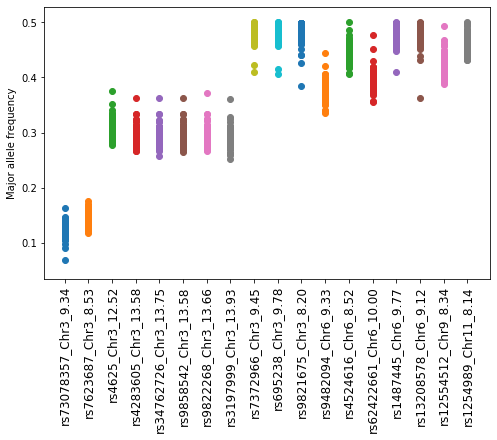

In [49]:
f,ax = plt.subplots(1,1,figsize=(8,5))

chrs = [3,3,3,3,3,3,3,3,3,3,3,6,6,6,6,6,9,11]
xlabs = []
# plot each snp
for i,snp in enumerate(sig_snps):
    xvals = np.zeros(len(allele_freqs[snp]))
    xvals = xvals + i
    ax.scatter(xvals,allele_freqs[snp])
    xlabs.append(snp + '_Chr' + str(chrs[i]) + '_' + '{:01.2f}'.format(pval_dict[snp]))

plt.ylabel('Major allele frequency')
xtickPos = np.arange(len(xlabs))
plt.xticks(xtickPos,xlabs,fontsize=12,rotation=90)    
plt.show()

In [ ]:
xlabs = [str(x) for x in sorted(positions.keys())]
    xtickPos = [x-0.5 for x in sorted(positions.keys())]
    plt.xticks(xtickPos,xlabs,fontsize=12)

# PLINK interaction term convolutedness